In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split

from lightgbm import LGBMRegressor

%matplotlib inline

# Обзор датасета

In [2]:
DATASET_TRAIN = 'C:/train.csv'
df = pd.read_csv(DATASET_TRAIN)

x = df.drop('Price', axis=1)
y = df[['Price']]

x.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [3]:
x.shape

(10000, 19)

In [4]:
DATASET_TEST = 'C:/test.csv'
x_final = pd.read_csv(DATASET_TEST)
x_final.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [5]:
x_final.shape

(5000, 19)

In [6]:
x.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [7]:
x['Id'] = x['Id'].astype(str)
x['DistrictId'] = x['DistrictId'].astype(str)
x['HouseFloor'] = x['HouseFloor'].astype(int)

x_final['Id'] = x_final['Id'].astype(str)
x_final['DistrictId'] = x_final['DistrictId'].astype(str)

preds_final = pd.DataFrame()
preds_final['Id'] = x_final['Id'].copy()


# Поиск выбросов и пропусков

In [8]:
x['Rooms'].value_counts().sort_values()

# Норма: 0 < Комнаты < 6

19.0       1
6.0        1
10.0       2
0.0        8
5.0       18
4.0      150
3.0     2235
1.0     3705
2.0     3880
Name: Rooms, dtype: int64

In [9]:
x['KitchenSquare'].value_counts().sort_values()

# Норма: 0 <= Площадь кухни < 25

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

In [10]:
x['Floor'].value_counts().unique()

# Норма: 0 < Этаж < 50

array([949, 876, 872, 802, 759, 643, 604, 588, 553, 457, 438, 398, 362,
       290, 287, 256, 235, 185, 121,  68,  59,  54,  53,  34,  25,  18,
         5,   3,   2,   1], dtype=int64)

In [11]:
x['HouseFloor'].value_counts().unique()

array([2331, 1389, 1074, 1031,  625,  576,  497,  374,  343,  269,  176,
        141,  135,  134,  127,  123,  108,  105,   89,   59,   58,   48,
         40,   33,   28,   27,   21,    7,    6,    4,    3,    2,    1],
      dtype=int64)

In [12]:
x['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [13]:
feat_numeric = list(x.select_dtypes(exclude='object').columns)
feat_object = list(x_final.select_dtypes(include='object').columns)


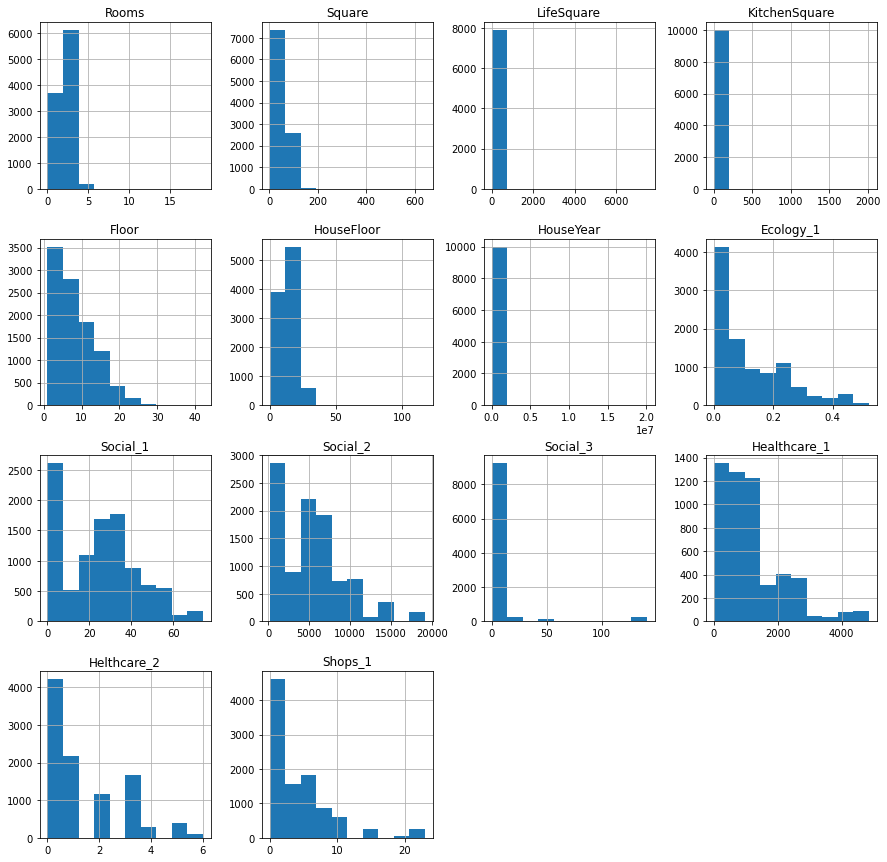

In [14]:
x[feat_numeric].hist(figsize=(15,15))
plt.show()

In [15]:
class FeatureImputer:
    
    def __init__(self):
        self.medians=None
        
    def fit(self, x):
        self.medians = x.median()
    
    def transform(self, x):
# Rooms
        x.loc[x['Rooms'] == 0, 'Rooms'] = 1
        x.loc[x['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
# KitchenSquare    
        x_sq = x[x['KitchenSquare'] <= x['Square']][['Square', 'KitchenSquare']].median()
        square = x_sq[0]
        kitchen = x_sq[1]

        x.loc[x['KitchenSquare'] > x['Square'], 'KitchenSquare'] = \
        x.loc[x['KitchenSquare'] > x['Square'], 'Square'] * kitchen/square
        x[x['KitchenSquare'] > x['Square']]
        
        x.loc[x['KitchenSquare'] > 25, 'KitchenSquare'] = self.medians['KitchenSquare']
        
# HouseFloor, Floor
       
        
        x.loc[x['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        x.loc[x['Floor'] > x['HouseFloor'], 'Floor'] = x.loc[x['Floor'] > x['HouseFloor'], 'HouseFloor']
        
# HouseYear
      
        x.loc[x['HouseYear'] > 2021, 'HouseYear'] = 2021

# LifeSquare
        x['LifeSquare_nan'] = x['LifeSquare'].isna() * 1
        
        condition = (x['LifeSquare'].isna()) &\
                      (~x['Square'].isna()) & \
                      (~x['KitchenSquare'].isna())
        
        x.loc[condition, 'LifeSquare'] = x.loc[condition, 'Square'] - x.loc[condition, 'KitchenSquare'] - 3
        
        return x

In [16]:
imputer = FeatureImputer()

imputer.fit(x)

x = imputer.transform(x)
x_final = imputer.transform(x_final)

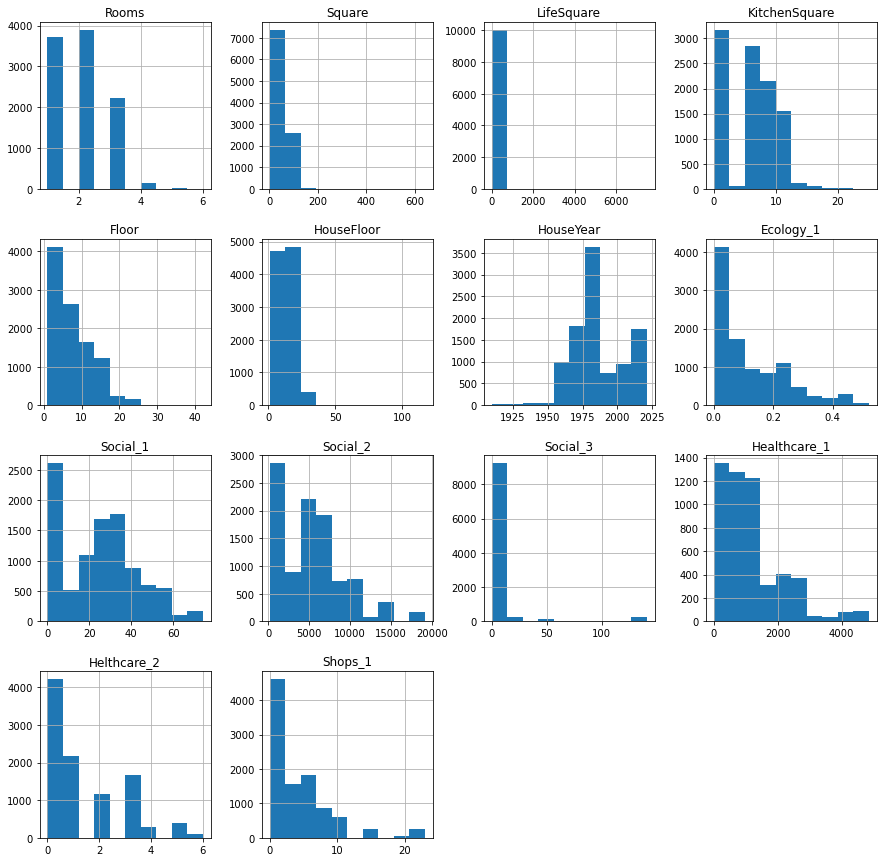

In [17]:
x[feat_numeric].hist(figsize=(15,15))
plt.show()


In [18]:
# Healthcare_1
if 'Healthcare_1' in x.columns:
    x.drop('Healthcare_1', axis=1, inplace=True)

# Генерация фич

In [19]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_2_year = None
        
    
    @staticmethod
    def year_to_cat(x):
        
        x['year_cat'] = np.nan
        
        x.loc[x['HouseYear'] < 1940, 'year_cat'] = 1
        x.loc[(x['HouseYear'] >= 1940) & (x['HouseYear'] < 1960), 'year_cat'] = 2
        x.loc[(x['HouseYear'] >= 1960) & (x['HouseYear'] < 1975), 'year_cat'] = 3
        x.loc[(x['HouseYear'] >= 1975) & (x['HouseYear'] < 1990), 'year_cat'] = 4
        x.loc[(x['HouseYear'] >= 1990) & (x['HouseYear'] < 2005), 'year_cat'] = 5
        x.loc[(x['HouseYear'] >= 2005), 'year_cat'] = 6
            
        return x
    
    @staticmethod
    def floor_to_cat_2(x):
        
        x['floor_cat_2'] = np.nan
        
        x.loc[x['Floor'] <= 2, 'floor_cat_2'] = 1
        x.loc[(x['Floor'] <= x['HouseFloor']*0.5) & (x['Floor']!=1) & (x['Floor']!=2) , 'floor_cat_2'] = 2
        x.loc[x['Floor'] > x['HouseFloor']*0.5, 'floor_cat_2'] = 3
        x.loc[(x['Floor'] >= x['HouseFloor'] - 1) | (x['Floor']==x['HouseFloor']), 'floor_cat_2'] = 4
            
        return x
    
    
    
    def objToNums (x):
        obj_to_num = {'A': 0, 'B': 1}
        x['Ecology_2'] = x['Ecology_2'].map(obj_to_num)
        x['Ecology_3'] = x['Ecology_3'].map(obj_to_num)
        x['Shops_2'] = x['Shops_2'].map(obj_to_num)
    
        return x
    
    x = objToNums(x)
    x_final = objToNums(x_final) 
    
    
    
     
    def fit(self, x, y=None):
        
        district = x['DistrictId'].value_counts()
        district = district[district > 50]
        
        self.DistrictId_counts = dict(district)
        
        x = x.copy()
        self.binary_to_numbers = {'A': 0, 'B': 1}
        df = x.copy()
        
            # price, disctrict
        if y is not None:
            df['Price'] = y.values
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})

            # year, floor_2
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat_2(df)
            df = self.year_to_cat(df)
            
            self.med_price_by_floor_2_year = df.groupby([ 'year_cat', 'floor_cat_2'], as_index=False).agg({'Price':'median'}).\
                                              rename(columns={'Price':'MedPriceByFloor_2_Year'})
            
             
        
    def transform(self, x):
        
        x['DistrictId_count'] = x['DistrictId'].map(self.DistrictId_counts)
        
                
        x = self.year_to_cat(x)   
        x = self.floor_to_cat_2(x)
        
        if self.med_price_by_district is not None:
            x = x.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_2_year is not None:
            x = x.merge(self.med_price_by_floor_2_year, on=[ 'year_cat', 'floor_cat_2'], how='left')    
        
        return x
    
            

In [20]:
features = FeatureGenetator()

features.fit(x, y)

x = features.transform(x)
x_final = features.transform(x_final)

In [21]:
x.head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,DistrictId_count,year_cat,floor_cat_2,MedPriceByDistrict,MedPriceByFloor_2_Year
0,14038,35,2.0,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,...,5,0,11,1,0,NaN,3.0,3.0,NaN,182528.188813
1,15053,41,3.0,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,...,1,1,16,1,0,87.0,4.0,3.0,300009.450063,181936.748986
2,4765,53,2.0,44.947953,29.197612,0.0,8.0,12.0,1968,0.049637,...,0,1,3,1,0,174.0,3.0,3.0,263206.223152,182528.188813
3,5809,58,2.0,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,...,3,0,5,1,0,179.0,4.0,2.0,166809.665642,175492.154294
4,10783,99,1.0,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,...,1,2,4,1,0,97.0,4.0,4.0,158539.052715,180420.595628
5,12915,59,3.0,80.384479,46.683720,12.0,5.0,17.0,2011,0.309479,...,4,0,6,1,0,67.0,6.0,2.0,466753.618497,173664.738484
6,14549,154,2.0,62.254114,37.160377,7.0,3.0,5.0,1960,0.460556,...,14,1,5,1,0,NaN,3.0,3.0,NaN,182528.188813
7,11993,74,2.0,80.312926,77.312926,0.0,13.0,13.0,1977,0.075779,...,3,0,2,1,1,114.0,4.0,4.0,243031.695525,180420.595628
8,5172,1,2.0,64.511437,60.511437,1.0,9.0,17.0,1977,0.007122,...,0,0,1,1,1,652.0,4.0,3.0,202666.310126,181936.748986
9,8649,23,1.0,46.461409,18.915552,8.0,13.0,17.0,2014,0.075779,...,3,0,2,1,0,565.0,6.0,3.0,102069.270740,179466.094235


In [22]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1', 'HouseFloor', 
                   'HouseYear', 'DistrictId_count', 'MedPriceByDistrict', 'MedPriceByFloor_2_Year']

x = x[remain_features]
x_final = x_final[remain_features]

# Модель

In [23]:
model = LGBMRegressor('gbdt', 
                              max_depth=5,
                             min_samples_leaf=2,
                             n_estimators=300,
                             random_state=42)

cv_score = cross_val_score(model, x, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
R2: 0.737 +- 0.018


In [24]:
model.fit(x, y)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(max_depth=5, min_samples_leaf=2, n_estimators=300,
              random_state=42)

In [25]:
y_pred_final = model.predict(x_final)


preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,163439.531328
1,15856,242150.823459
2,5480,217231.298246
3,15664,303938.524135
4,14275,141761.068151
